### This notebook is a tutorial for the PERT infer scRT module.

PERT takes binned read counts with called copy number states as input from scWGS. Cells are split into high-confidence G1/2-phase and unknown phase sets of cells before passing data into the probabilistic model.

Here, we are analyzing simulated data from 400 S-phase cells and 400 G1-phase cells with no CNAs. HMMcopy has been run on the simulated data to obtain the `copy` and `state` columns.

In [1]:
%%capture
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scdna_replication_tools.infer_scRT import scRT
from scdna_replication_tools.plot_pert_output import plot_model_results
from scdna_replication_tools.compute_ccc_features import compute_ccc_features

In [2]:
# load the simulated data from the paper
# this corresponds to the data seen in simulated dataset P5.8 which has subclonal and cell-specific CNAs
cn_s = pd.read_csv('data/P8.5/s_phase_cells_hmmcopy.csv.gz')
cn_g1 = pd.read_csv('data/P8.5/g1_phase_cells_hmmcopy.csv.gz')
cn_s.head()

,cell_id,chr,start,end,reads,gc,map,copy,state,multiplier,...,clone_cn_state,true_G1_state,library_id,true_reads_norm,true_reads_raw,true_rep,true_p_rep,true_t,observed_cn_state,true_cell_frac_rep
0,cell_S_0,1,2000000,2500000,731,0.594508,0.997066,0.939552,1,1,...,2.0,2.0,ABCD,376,731.0,1.0,0.997416,0.45004,4.0,0.439185
1,cell_S_0,1,4500000,5000000,225,0.481828,0.999002,0.591276,1,1,...,2.0,2.0,ABCD,115,225.0,0.0,0.015201,0.45004,2.0,0.439185
2,cell_S_0,1,6500000,7000000,529,0.489968,0.999179,1.316536,1,1,...,2.0,2.0,ABCD,272,529.0,1.0,0.994473,0.45004,4.0,0.439185
3,cell_S_0,1,7500000,8000000,571,0.488250,0.998566,1.437474,2,1,...,2.0,2.0,ABCD,294,571.0,1.0,0.976151,0.45004,4.0,0.439185
4,cell_S_0,1,8000000,8500000,600,0.462702,0.998576,1.790551,2,1,...,2.0,2.0,ABCD,309,600.0,1.0,0.986320,0.45004,4.0,0.439185


In [3]:
cn_g1.head()

,cell_id,chr,start,end,reads,gc,map,copy,state,multiplier,...,nhek_rt,bin_size,clone_id,clone_cn_state,true_G1_state,library_id,true_reads_norm,true_reads_raw,observed_cn_state,true_cell_frac_rep
0,cell_G_0,1,2000000,2500000,538,0.594508,0.997066,2.142163,2,2,...,72.161813,500000,A,2.0,2.0,ABCD,273,538.0,2.0,0.0
1,cell_G_0,1,4500000,5000000,429,0.481828,0.999002,2.101723,2,2,...,40.645100,500000,A,2.0,2.0,ABCD,218,429.0,2.0,0.0
2,cell_G_0,1,6500000,7000000,529,0.489968,0.999179,2.553351,2,2,...,67.336678,500000,A,2.0,2.0,ABCD,268,529.0,2.0,0.0
3,cell_G_0,1,7500000,8000000,380,0.488250,0.998566,1.839941,2,2,...,60.800801,500000,A,2.0,2.0,ABCD,193,380.0,2.0,0.0
4,cell_G_0,1,8000000,8500000,395,0.462702,0.998576,2.003717,2,2,...,70.025844,500000,A,2.0,2.0,ABCD,200,395.0,2.0,0.0


In [4]:
# add the replication columns for the G1-phase cells
cn_g1['true_rep'] = 0.0
cn_g1['true_p_rep'] = 0.0
cn_g1['true_t'] = 1.0

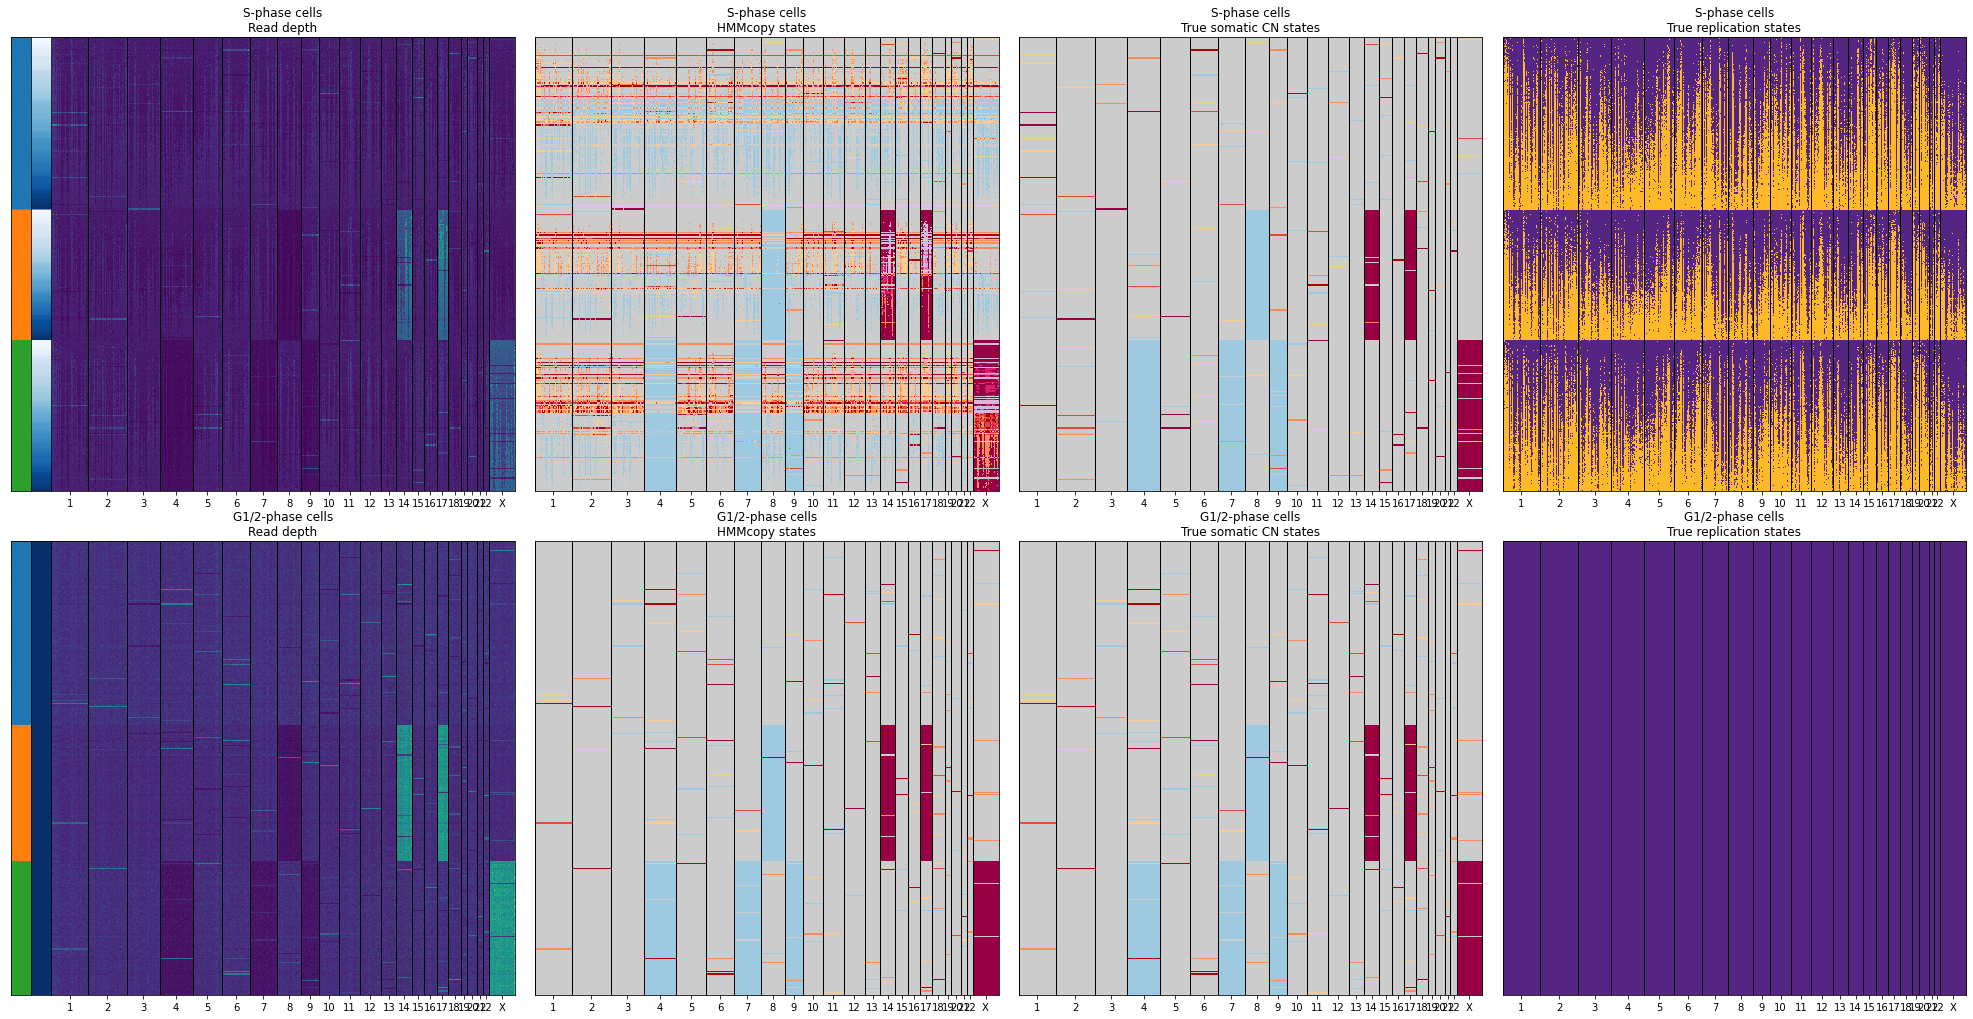

In [5]:
# plot the true simulated data
plot_model_results(
    cn_s, cn_g1, clone_col='clone_id', second_sort_col='true_t', 
    input_cn_col='state', output_cn_col='true_G1_state', 
    output_rep_col='true_rep', rpm_col='true_reads_norm',
    rpm_title='Read depth', input_cn_title='HMMcopy states',
    output_cn_title='True somatic CN states', rep_title='True replication states'
)
plt.show()

In the above plots, note how the HMMcopy `state` column accurately reflects somatic CN for G1/2-phase cells but not S-phase cells. This is because the HMMcopy model is not designed to handle the high copy number of S-phase cells. Given that replication origins are disproportionately located in high GC regions, some of the replication signal gets regressed out during per-cell GC normalization (1st step of hmmcopy). Thus, many replicated vs unreplicated bins in S-phase cells don't have clear 2:1 ratios, leading HMMcopy to select an erroneously high ploidy multiplier (2nd step of hmmcopy). Even if the ploidy multiplier is correct, the HMMcopy states only reflect the replicated signal that remains after GC normalization, so the states should be ignored in S-phase cells.

### First we need to identify the high confidence G1/2-phase cells based on per-cell features.

In [6]:
# note the true cell cycle phase of each cell and merge all the cells into one dataframe
cn_s['true_phase'] = 'S'
cn_g1['true_phase'] = 'G1/2'

cn = pd.concat([cn_s, cn_g1], ignore_index=True)
cn.head()

,cell_id,chr,start,end,reads,gc,map,copy,state,multiplier,...,library_id,true_reads_norm,true_reads_raw,true_rep,true_p_rep,true_t,observed_cn_state,true_cell_frac_rep,cluster_id,true_phase
0,cell_S_0,1,2000000,2500000,731,0.594508,0.997066,0.939552,1,1,...,ABCD,376,731.0,1.0,0.997416,0.45004,4.0,0.439185,A,S
1,cell_S_0,1,4500000,5000000,225,0.481828,0.999002,0.591276,1,1,...,ABCD,115,225.0,0.0,0.015201,0.45004,2.0,0.439185,A,S
2,cell_S_0,1,6500000,7000000,529,0.489968,0.999179,1.316536,1,1,...,ABCD,272,529.0,1.0,0.994473,0.45004,4.0,0.439185,A,S
3,cell_S_0,1,7500000,8000000,571,0.488250,0.998566,1.437474,2,1,...,ABCD,294,571.0,1.0,0.976151,0.45004,4.0,0.439185,A,S
4,cell_S_0,1,8000000,8500000,600,0.462702,0.998576,1.790551,2,1,...,ABCD,309,600.0,1.0,0.986320,0.45004,4.0,0.439185,A,S


In [7]:
# compute per-cell features for all cells
cn, cell_features = compute_ccc_features(
    cn, rpm_col='true_reads_norm', cn_col='state', 
    clone_col='clone_id', madn_col='madn', lrs_col='lrs',
    num_reads_col='total_reads_per_cell', bk_col='breakpoints'
)
cell_features.head()

,cell_id,clone_id,madn,lrs,total_reads_per_cell,breakpoints,corrected_madn,corrected_breakpoints
0,cell_S_0,A,0.152055,0.630541,573878,818,0.004739,592.512739
3206,cell_S_1,A,0.196427,0.198551,576776,165,0.050061,-60.487261
6412,cell_S_10,C,0.136971,0.482403,577056,913,-0.009303,778.243028
9618,cell_S_100,A,0.130042,0.190491,581811,228,-0.014674,2.512739
12824,cell_S_101,B,0.167150,0.160855,574649,400,0.020087,262.808511


In [8]:
cn.head()

,cell_id,chr,start,end,reads,gc,map,copy,state,multiplier,...,observed_cn_state,true_cell_frac_rep,cluster_id,true_phase,true_reads_norm_clone_norm,madn,lrs,total_reads_per_cell,corrected_madn,corrected_breakpoints
0,cell_S_0,1,2000000,2500000,731,0.594508,0.997066,0.939552,1,1,...,4.0,0.439185,A,S,1.368192,0.152055,0.630541,573878,0.004739,592.512739
1,cell_S_0,1,4500000,5000000,225,0.481828,0.999002,0.591276,1,1,...,2.0,0.439185,A,S,0.615592,0.152055,0.630541,573878,0.004739,592.512739
2,cell_S_0,1,6500000,7000000,529,0.489968,0.999179,1.316536,1,1,...,4.0,0.439185,A,S,1.174025,0.152055,0.630541,573878,0.004739,592.512739
3,cell_S_0,1,7500000,8000000,571,0.488250,0.998566,1.437474,2,1,...,4.0,0.439185,A,S,1.308370,0.152055,0.630541,573878,0.004739,592.512739
4,cell_S_0,1,8000000,8500000,600,0.462702,0.998576,1.790551,2,1,...,4.0,0.439185,A,S,1.383753,0.152055,0.630541,573878,0.004739,592.512739


In [9]:
# merge the true_phase information back into the cell_features dataframe
cell_features = cell_features.merge(cn[['cell_id', 'true_phase']].drop_duplicates(), on='cell_id')
cell_features.head()

,cell_id,clone_id,madn,lrs,total_reads_per_cell,breakpoints,corrected_madn,corrected_breakpoints,true_phase
0,cell_S_0,A,0.152055,0.630541,573878,818,0.004739,592.512739,S
1,cell_S_1,A,0.196427,0.198551,576776,165,0.050061,-60.487261,S
2,cell_S_10,C,0.136971,0.482403,577056,913,-0.009303,778.243028,S
3,cell_S_100,A,0.130042,0.190491,581811,228,-0.014674,2.512739,S
4,cell_S_101,B,0.167150,0.160855,574649,400,0.020087,262.808511,S


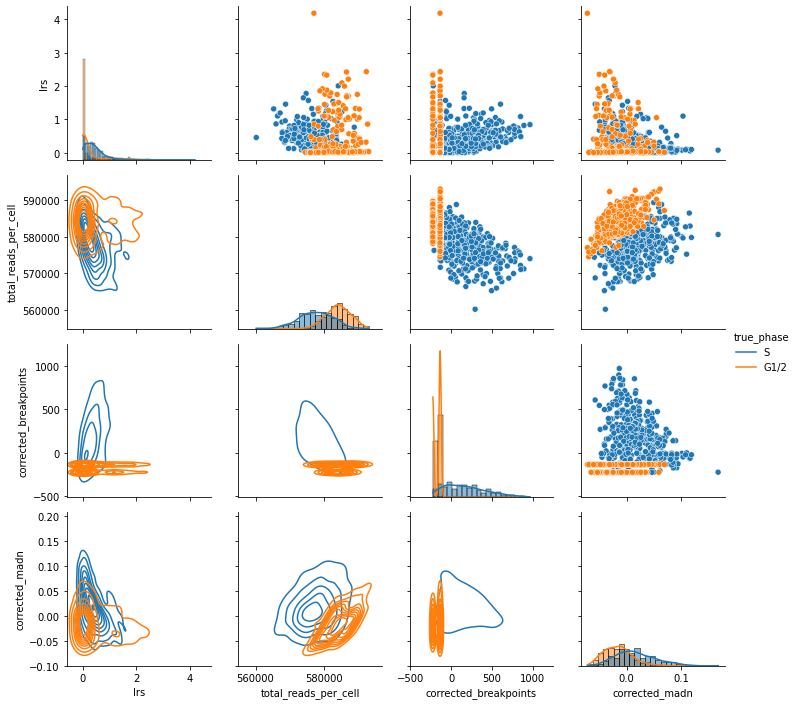

In [10]:
# plot a distribution of the per-cell features, colored by the true cell cycle phase
plot_cols = ['lrs', 'total_reads_per_cell', 'corrected_breakpoints', 'corrected_madn', 'true_phase']
g = sns.PairGrid(cell_features[plot_cols], hue='true_phase')
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.histplot, kde=True)
g.add_legend()
plt.show()

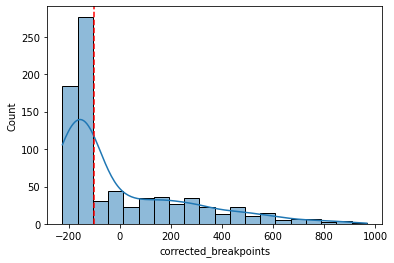

In [13]:
# look at distribution of corrected breakpoints to set a threshold for identifying the high-confidence G1/2-phase cells
thresh = -100
sns.histplot(cell_features['corrected_breakpoints'], kde=True)
# plot a vertical line at the threshold
plt.axvline(thresh, color='red', linestyle='--')
plt.show()

In [65]:
# use the threshold of corrected_breakpoints==-100 to identify the high-confidence G1/2-phase cells
thresh=-100
cn_g_input = cn[cn['corrected_breakpoints'] < thresh].reset_index(drop=True)
cn_s_input = cn[cn['corrected_breakpoints'] >= thresh].reset_index(drop=True)
cn_g_input.cell_id.unique().shape

(317,)

In [68]:
# split the data so cells with the 400 highest corrected breakpoints are in the G1/2-phase dataset
# sort the cells by corrected breakpoints
cell_features = cell_features.sort_values('corrected_breakpoints', ascending=False)
# get the cell_ids for the top 400 cells
top_400_cell_ids = list(cell_features['cell_id'].iloc[:400].values)
# split the data into G1/2-phase and S-phase
cn_s_input = cn[cn['cell_id'].isin(top_400_cell_ids)].reset_index(drop=True)
cn_g_input = cn[~cn['cell_id'].isin(top_400_cell_ids)].reset_index(drop=True)
cn_g_input.cell_id.unique().shape

(400,)

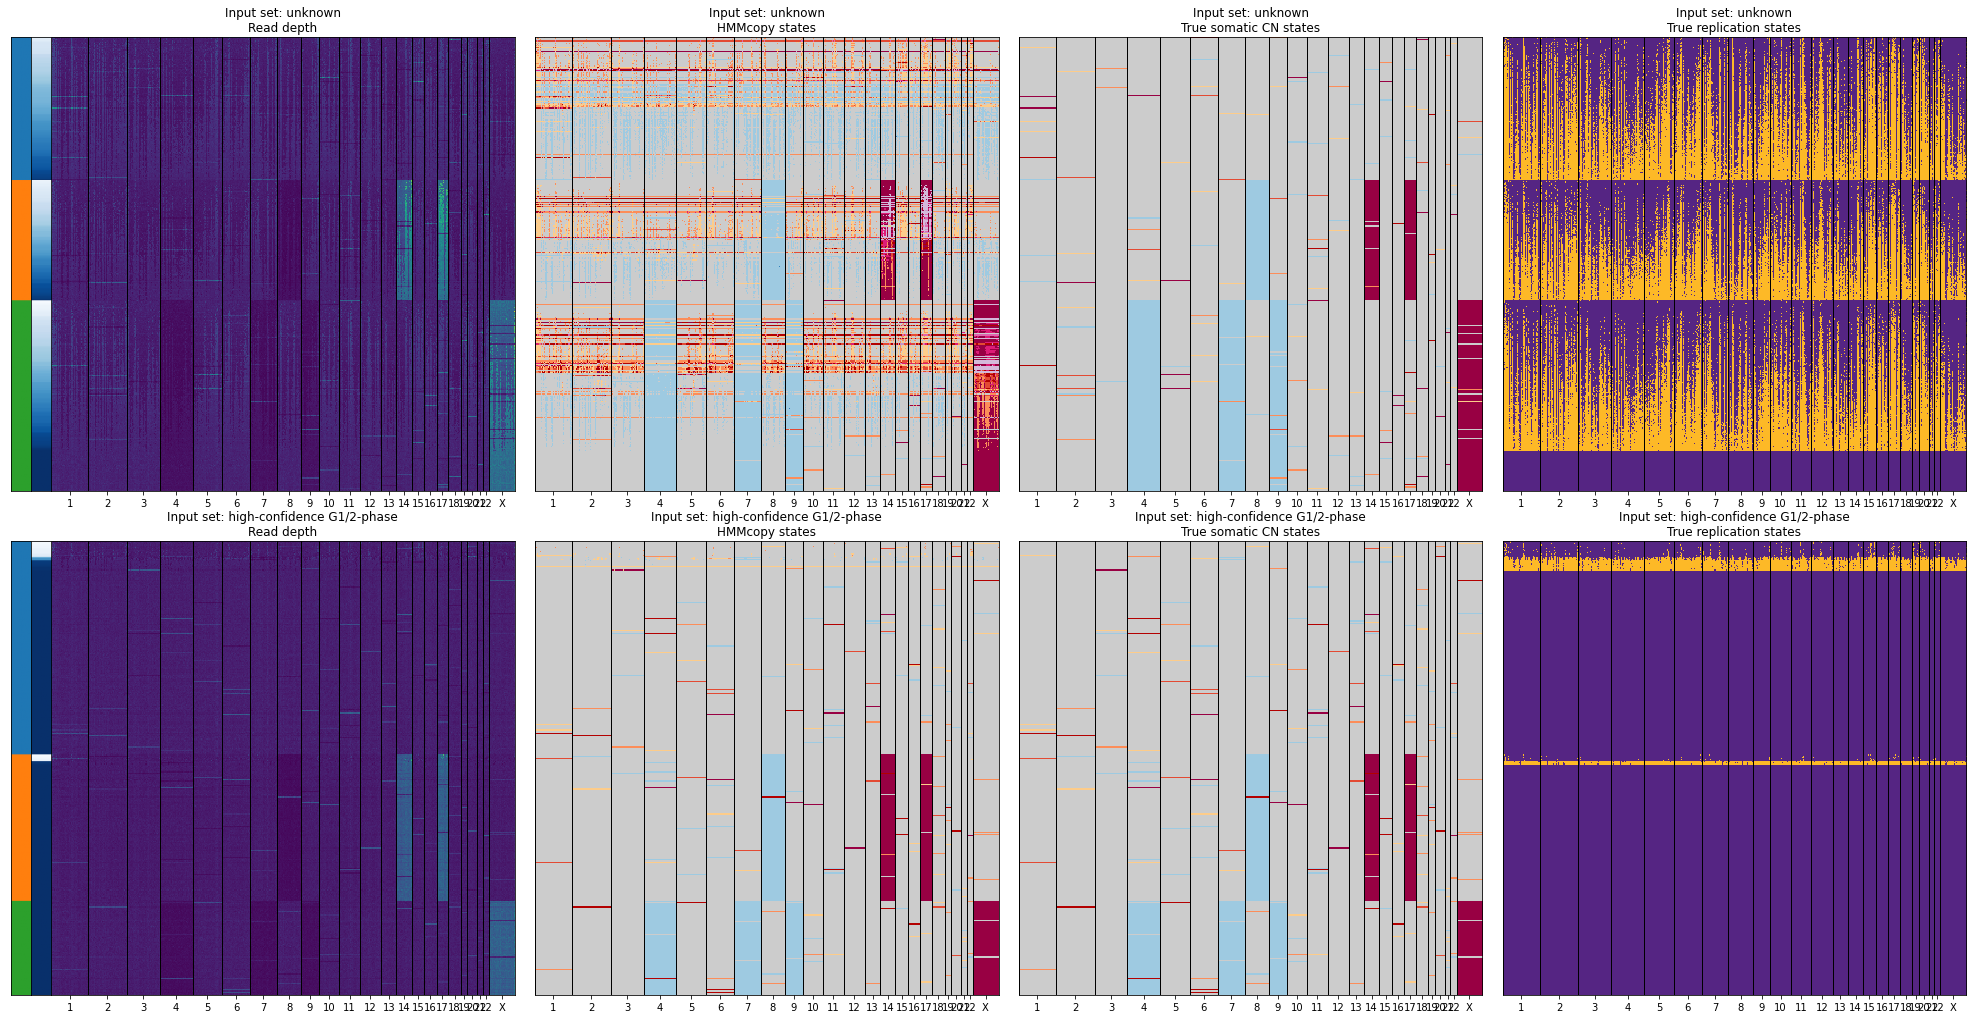

In [69]:
# plot the true simulated data according to the input splits
plot_model_results(
    cn_s_input, cn_g_input, clone_col='clone_id', second_sort_col='true_t',
    input_cn_col='state', output_cn_col='true_G1_state',
    output_rep_col='true_rep', rpm_col='true_reads_norm',
    rpm_title='Read depth', input_cn_title='HMMcopy states',
    output_cn_title='True somatic CN states', rep_title='True replication states',
    top_title_prefix='Input set: unknown', bottom_title_prefix='Input set: high-confidence G1/2-phase',
)
plt.show()

### Now we will run PERT to jointly infer scRT and CN states for all cells.

We are going to limit this example to just chromosomes 1-3 to speed up the analysis. We will also use a small number of iterations to speed up the analysis. In practice, we recommend using >1000 iterations and all chromosomes. One can also adjust the `learning_rate` and `rel_tol` away from default values of 0.05 and 1e-6, respectively, to achieve a desired optimization routine.

In [70]:
# temporarily remove columns that don't get used by PERT
temp_cn_s = cn_s_input[['cell_id', 'chr', 'start', 'end', 'gc', 'state', 'library_id', 'true_reads_norm']]
temp_cn_g1 = cn_g_input[['cell_id', 'chr', 'start', 'end', 'gc', 'clone_id', 'state', 'library_id', 'true_reads_norm']]

# subset to only include chromosomes 6-8 for speed
temp_cn_s = temp_cn_s[(temp_cn_s['chr'] == '6') | (temp_cn_s['chr'] == '7') | (temp_cn_s['chr'] == '8')]
temp_cn_g1 = temp_cn_g1[(temp_cn_g1['chr'] == '6') | (temp_cn_g1['chr'] == '7') | (temp_cn_g1['chr'] == '8')]
print('number of cells in S-phase: ', len(temp_cn_s['cell_id'].unique()))
print('number of cells in G1-phase: ', len(temp_cn_g1['cell_id'].unique()))
print('number of loci in S-phase: ', len(temp_cn_s[['chr', 'start']].drop_duplicates()))
print('number of loci in G1-phase: ', len(temp_cn_g1[['chr', 'start']].drop_duplicates()))

number of cells in S-phase:  400
number of cells in G1-phase:  400
number of loci in S-phase:  545
number of loci in G1-phase:  545


In [71]:
temp_cn_g1.dtypes

cell_id             object
chr                 object
start                int64
end                  int64
gc                 float64
clone_id            object
state                int64
library_id          object
true_reads_norm      int64
dtype: object

In [72]:
cn_g1[['cell_id', 'chr', 'start', 'end', 'gc', 'clone_id', 'state', 'library_id', 'true_reads_norm']].dtypes

cell_id              object
chr                category
start                 int64
end                   int64
gc                  float64
clone_id             object
state                 int64
library_id           object
true_reads_norm       int64
dtype: object

In [73]:
# convert chr to string for input into scRT module
# this might explain the odd error I was getting
temp_cn_s['chr'] = temp_cn_s['chr'].astype(str)
temp_cn_g1['chr'] = temp_cn_g1['chr'].astype(str)
temp_cn_g1.dtypes

cell_id             object
chr                 object
start                int64
end                  int64
gc                 float64
clone_id            object
state                int64
library_id          object
true_reads_norm      int64
dtype: object

In [74]:
temp_cn_g1.library_id.unique(), cn_g1.library_id.unique()

(array(['ABCD'], dtype=object), array(['ABCD'], dtype=object))

In [75]:
# try to see if an error arises when computing library tensors
import torch

def get_libraries_tensor(cn_s, cn_g1, cell_col='cell_id', library_col='library_id'):
    """ Create a tensor of integers representing the unique library_id of each cell. """
    libs_s = cn_s[[cell_col, library_col]].drop_duplicates()
    libs_g1 = cn_g1[[cell_col, library_col]].drop_duplicates()

    # get all unique library ids found across cells of both cell cycle phases
    all_library_ids = pd.concat([libs_s, libs_g1])[library_col].unique()

    L = int(len(all_library_ids))
    
    # replace library_id strings with integer values
    for i, library_id in enumerate(all_library_ids):
        libs_s[library_col].replace(library_id, i, inplace=True)
        libs_g1[library_col].replace(library_id, i, inplace=True)
    
    # convert to tensors of type int (ints needed to index other tensors)
    libs_s = torch.tensor(libs_s[library_col].values).to(torch.int64)
    libs_g1 = torch.tensor(libs_g1[library_col].values).to(torch.int64)

    return libs_s, libs_g1


libs_s, libs_g1 = get_libraries_tensor(temp_cn_s, temp_cn_g1)

In [76]:
len(libs_s), len(libs_g1)

(400, 400)

In [77]:
libs_s

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [78]:
libs_g1

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [79]:
# now try to create libs_s and libs_g1 tensors if we hadn't split the cells manually
libs_s, libs_g1 = get_libraries_tensor(cn_s, cn_g1)
print(len(libs_s), len(libs_g1))
libs_g1, libs_s

400 400


(tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0

In [80]:
from scdna_replication_tools.pert_model import pert_infer_scRT

# create scRT object with input columns denoted
scrt = pert_infer_scRT(
    temp_cn_s, temp_cn_g1, input_col='true_reads_norm', clone_col='clone_id', assign_col='state', rt_prior_col=None,
    cn_state_col='state', gc_col='gc', cn_prior_method='g1_composite', max_iter=200)

In [81]:
cn_g1_reads_df, cn_g1_states_df, cn_s_reads_df, cn_s_states_df, \
    cn_g1_reads, cn_g1_states, cn_s_reads, cn_s_states, \
    gammas, rt_prior_profile, libs_g1, libs_s = scrt.process_input_data()

In [82]:
cn_g1_reads_df.shape, cn_g1_states_df.shape, cn_s_reads_df.shape, cn_s_states_df.shape

((545, 400), (545, 400), (545, 400), (545, 400))

In [83]:
cn_g1_reads.shape, cn_g1_states.shape, cn_s_reads.shape, cn_s_states.shape

(torch.Size([545, 400]),
 torch.Size([545, 400]),
 torch.Size([545, 400]),
 torch.Size([545, 400]))

In [84]:
gammas.shape, libs_g1.shape, libs_s.shape

(torch.Size([545]), torch.Size([400]), torch.Size([400]))

In [85]:
# create the same scRT objects and processed input data but for the original data (no error)
scrt2 = pert_infer_scRT(
    cn_s, cn_g1, input_col='true_reads_norm', clone_col='clone_id', assign_col='state', rt_prior_col=None,
    cn_state_col='state', gc_col='gc', cn_prior_method='g1_composite', max_iter=200)

In [86]:
# process input data
cn_g1_reads_df2, cn_g1_states_df2, cn_s_reads_df2, cn_s_states_df2, \
    cn_g1_reads2, cn_g1_states2, cn_s_reads2, cn_s_states2, \
    gammas2, rt_prior_profile2, libs_g1_2, libs_s_2 = scrt2.process_input_data()

cn_g1_reads_df2.shape, cn_g1_states_df2.shape, cn_s_reads_df2.shape, cn_s_states_df2.shape

((3206, 400), (3206, 400), (3206, 400), (3206, 400))

In [87]:
# examine the data which gets input into model_g1
gammas2.shape, libs_g1_2.shape, cn_g1_states2.shape, cn_g1_reads2.shape

(torch.Size([3206]),
 torch.Size([400]),
 torch.Size([3206, 400]),
 torch.Size([3206, 400]))

In [88]:
# examine the data which gets input into model_g1
gammas.shape, libs_g1.shape, cn_g1_states.shape, cn_g1_reads.shape

(torch.Size([545]),
 torch.Size([400]),
 torch.Size([545, 400]),
 torch.Size([545, 400]))

In [89]:
gammas, gammas2

(tensor([0.4188, 0.4051, 0.4367, 0.4454, 0.4193, 0.4255, 0.4090, 0.4475, 0.4437,
         0.4299, 0.3973, 0.3722, 0.3704, 0.3768, 0.4240, 0.4040, 0.3973, 0.4299,
         0.4128, 0.4328, 0.4375, 0.4435, 0.4201, 0.4065, 0.4156, 0.3777, 0.3806,
         0.3918, 0.4068, 0.4241, 0.3704, 0.3695, 0.3997, 0.3904, 0.4270, 0.4089,
         0.3814, 0.4574, 0.5146, 0.5216, 0.4421, 0.4560, 0.4134, 0.4612, 0.4197,
         0.4580, 0.4558, 0.4620, 0.4492, 0.4797, 0.3945, 0.3916, 0.3538, 0.3638,
         0.3582, 0.3752, 0.3864, 0.4218, 0.4127, 0.3620, 0.3522, 0.3729, 0.3886,
         0.3798, 0.3492, 0.3495, 0.3715, 0.3864, 0.3381, 0.3449, 0.3492, 0.3448,
         0.3546, 0.3534, 0.3649, 0.3678, 0.3842, 0.3868, 0.3707, 0.3590, 0.3876,
         0.4280, 0.3800, 0.3598, 0.3830, 0.3772, 0.3667, 0.3683, 0.3669, 0.3741,
         0.3484, 0.3636, 0.3758, 0.3766, 0.3786, 0.3848, 0.3990, 0.3858, 0.3854,
         0.4218, 0.3772, 0.3507, 0.3478, 0.3551, 0.3443, 0.3531, 0.3643, 0.3496,
         0.3615, 0.3813, 0.3

In [90]:
libs_g1, libs_g1_2

(tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0

In [91]:
cn_g1_reads, cn_g1_reads2

(tensor([[213., 197., 152.,  ..., 164., 195., 177.],
         [163., 180., 135.,  ..., 139., 148., 197.],
         [204., 183., 188.,  ..., 168.,  87., 205.],
         ...,
         [236., 163., 203.,  ..., 252.,  57., 197.],
         [208., 179., 217.,  ..., 434., 116., 218.],
         [255., 194., 232.,  ..., 462., 185., 190.]]),
 tensor([[273., 187., 256.,  ..., 196., 359., 292.],
         [218., 151., 172.,  ..., 183., 222., 203.],
         [268., 180., 238.,  ..., 196., 224., 190.],
         ...,
         [212., 181., 786.,  ..., 185., 252., 224.],
         [188., 160., 574.,  ..., 196., 206., 154.],
         [193., 186., 606.,  ..., 164., 183., 152.]]))

In [92]:
cn_g1_states, cn_g1_states2

(tensor([[2., 2., 2.,  ..., 2., 2., 2.],
         [2., 2., 2.,  ..., 2., 2., 2.],
         [2., 2., 2.,  ..., 2., 2., 2.],
         ...,
         [2., 2., 2.,  ..., 2., 1., 2.],
         [2., 2., 2.,  ..., 4., 1., 2.],
         [2., 2., 2.,  ..., 4., 1., 2.]]),
 tensor([[2., 2., 2.,  ..., 2., 2., 2.],
         [2., 2., 2.,  ..., 2., 2., 2.],
         [2., 2., 2.,  ..., 2., 2., 2.],
         ...,
         [2., 2., 7.,  ..., 2., 2., 2.],
         [2., 2., 7.,  ..., 2., 2., 2.],
         [2., 2., 7.,  ..., 2., 2., 2.]]))

In [93]:
gammas2.dtype, libs_g1_2.dtype, cn_g1_states2.dtype, cn_g1_reads2.dtype

(torch.float32, torch.int64, torch.float32, torch.float32)

In [94]:
gammas.dtype, libs_g1.dtype, cn_g1_states.dtype, cn_g1_reads.dtype

(torch.float32, torch.int64, torch.float32, torch.float32)

In [95]:
# look at the L and K values for both model classes
scrt2.L, scrt2.K, scrt.L, scrt.K

(1, 4, 1, 4)

In [96]:
%%capture

# create scRT object with input columns denoted
scrt = scRT(temp_cn_s, temp_cn_g1, input_col='true_reads_norm', clone_col='clone_id', assign_col='state', rt_prior_col=None,
            cn_state_col='state', gc_col='gc', cn_prior_method='g1_composite', max_iter=200)

# run inference using PERT
cn_s_with_scrt, supp_s_output, cn_g_with_scrt, supp_g_output = scrt.infer(level='pyro')

RuntimeError: The following operation failed in the TorchScript interpreter.
Traceback of TorchScript (most recent call last):
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/pyro/ops/special.py(32): safe_log
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/pyro/ops/einsum/torch_log.py(54): einsum
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/pyro/ops/einsum/torch_sample.py(68): einsum
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/opt_einsum/contract.py(353): _einsum
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/opt_einsum/sharing.py(101): _memoize
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/opt_einsum/sharing.py(168): cached_einsum
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/opt_einsum/contract.py(591): _core_contract
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/opt_einsum/contract.py(698): _contract
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/opt_einsum/contract.py(763): __call__
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/pyro/ops/einsum/__init__.py(46): contract
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/pyro/ops/rings.py(199): sumproduct
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/pyro/ops/contract.py(125): _contract_component
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/pyro/ops/contract.py(200): contract_tensor_tree
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/pyro/infer/traceenum_elbo.py(199): _compute_dice_elbo
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/pyro/infer/traceenum_elbo.py(556): differentiable_loss
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/pyro/poutine/messenger.py(12): _context_wrap
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/pyro/ops/jit.py(99): compiled
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/torch/jit/_trace.py(802): trace
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/pyro/ops/jit.py(108): __call__
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/pyro/infer/traceenum_elbo.py(561): differentiable_loss
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/pyro/infer/traceenum_elbo.py(564): loss_and_grads
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/pyro/infer/svi.py(145): step
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/scdna_replication_tools/pert_model.py(804): run_pert_model
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/scdna_replication_tools/infer_scRT.py(164): infer_pert_model
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/scdna_replication_tools/infer_scRT.py(120): infer
<ipython-input-96-6dff24ff4f2c>(6): <module>
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py(3326): run_code
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py(3249): run_ast_nodes
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py(3058): run_cell_async
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/IPython/core/async_helpers.py(68): _pseudo_sync_runner
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py(2881): _run_cell
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py(2855): run_cell
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/ipykernel/zmqshell.py(539): run_cell
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/IPython/core/magics/execution.py(1452): capture
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/IPython/core/magic.py(187): <lambda>
</juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/decorator.py:decorator-gen-63>(2): capture
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py(2359): run_cell_magic
<ipython-input-96-798b3b0f479d>(1): <module>
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py(3326): run_code
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py(3249): run_ast_nodes
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py(3058): run_cell_async
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/IPython/core/async_helpers.py(68): _pseudo_sync_runner
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py(2881): _run_cell
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py(2855): run_cell
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/ipykernel/zmqshell.py(539): run_cell
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py(302): do_execute
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/tornado/gen.py(234): wrapper
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/ipykernel/kernelbase.py(538): execute_request
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/tornado/gen.py(234): wrapper
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/ipykernel/kernelbase.py(261): dispatch_shell
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/tornado/gen.py(234): wrapper
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/ipykernel/kernelbase.py(358): process_one
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/tornado/gen.py(775): run
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/tornado/gen.py(814): inner
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/tornado/ioloop.py(741): _run_callback
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/tornado/ioloop.py(688): <lambda>
/juno/work/shah/users/weinera2/miniconda3/envs/scdna_replication_tools/lib/python3.7/asyncio/events.py(88): _run
/juno/work/shah/users/weinera2/miniconda3/envs/scdna_replication_tools/lib/python3.7/asyncio/base_events.py(1771): _run_once
/juno/work/shah/users/weinera2/miniconda3/envs/scdna_replication_tools/lib/python3.7/asyncio/base_events.py(534): run_forever
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/tornado/platform/asyncio.py(199): start
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/ipykernel/kernelapp.py(612): start
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/traitlets/config/application.py(664): launch_instance
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/ipykernel_launcher.py(16): <module>
/juno/work/shah/users/weinera2/miniconda3/envs/scdna_replication_tools/lib/python3.7/runpy.py(85): _run_code
/juno/work/shah/users/weinera2/miniconda3/envs/scdna_replication_tools/lib/python3.7/runpy.py(193): _run_module_as_main
RuntimeError: KeyboardInterrupt: 

At:
  /juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/pyro/ops/special.py(16): forward
  /juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/pyro/ops/jit.py(120): __call__
  /juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/pyro/infer/traceenum_elbo.py(561): differentiable_loss
  /juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/pyro/infer/traceenum_elbo.py(564): loss_and_grads
  /juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/pyro/infer/svi.py(145): step
  /juno/work/shah/users/weinera2/projects/scdna_replication_tools/scdna_replication_tools/pert_model.py(804): run_pert_model
  /juno/work/shah/users/weinera2/projects/scdna_replication_tools/scdna_replication_tools/infer_scRT.py(164): infer_pert_model
  /juno/work/shah/users/weinera2/projects/scdna_replication_tools/scdna_replication_tools/infer_scRT.py(120): infer
  <ipython-input-96-6dff24ff4f2c>(6): <module>
  /juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py(3326): run_code
  /juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py(3249): run_ast_nodes
  /juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py(3058): run_cell_async
  /juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/IPython/core/async_helpers.py(68): _pseudo_sync_runner
  /juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py(2881): _run_cell
  /juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py(2855): run_cell
  /juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/ipykernel/zmqshell.py(539): run_cell
  /juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/IPython/core/magics/execution.py(1452): capture
  /juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/IPython/core/magic.py(187): <lambda>
  </juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/decorator.py:decorator-gen-63>(2): capture
  /juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py(2359): run_cell_magic
  <ipython-input-96-798b3b0f479d>(1): <module>
  /juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py(3326): run_code
  /juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py(3249): run_ast_nodes
  /juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py(3058): run_cell_async
  /juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/IPython/core/async_helpers.py(68): _pseudo_sync_runner
  /juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py(2881): _run_cell
  /juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py(2855): run_cell
  /juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/ipykernel/zmqshell.py(539): run_cell
  /juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py(302): do_execute
  /juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/tornado/gen.py(234): wrapper
  /juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/ipykernel/kernelbase.py(538): execute_request
  /juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/tornado/gen.py(234): wrapper
  /juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/ipykernel/kernelbase.py(261): dispatch_shell
  /juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/tornado/gen.py(234): wrapper
  /juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/ipykernel/kernelbase.py(358): process_one
  /juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/tornado/gen.py(775): run
  /juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/tornado/gen.py(814): inner
  /juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/tornado/ioloop.py(741): _run_callback
  /juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/tornado/ioloop.py(688): <lambda>
  /juno/work/shah/users/weinera2/miniconda3/envs/scdna_replication_tools/lib/python3.7/asyncio/events.py(88): _run
  /juno/work/shah/users/weinera2/miniconda3/envs/scdna_replication_tools/lib/python3.7/asyncio/base_events.py(1771): _run_once
  /juno/work/shah/users/weinera2/miniconda3/envs/scdna_replication_tools/lib/python3.7/asyncio/base_events.py(534): run_forever
  /juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/tornado/platform/asyncio.py(199): start
  /juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/ipykernel/kernelapp.py(612): start
  /juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/traitlets/config/application.py(664): launch_instance
  /juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/ipykernel_launcher.py(16): <module>
  /juno/work/shah/users/weinera2/miniconda3/envs/scdna_replication_tools/lib/python3.7/runpy.py(85): _run_code
  /juno/work/shah/users/weinera2/miniconda3/envs/scdna_replication_tools/lib/python3.7/runpy.py(193): _run_module_as_main



the lack of an error above makes me think that there's some issue when `temp_cn_s` and `temp_cn_g` have different numbers of cells... I'll look into this...

In [ ]:
cn_s_with_scrt.head()

In [ ]:
cn_g_with_scrt.head()

In [ ]:
# plot the loss curve for 'loss_s' and 'loss_g' param values in the supp_s_output and supp_g_output dataframes
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
sns.lineplot(data=supp_s_output.query("param=='loss_g'"), x='level', y='value', ax=ax[0])
sns.lineplot(data=supp_s_output.query("param=='loss_s'"), x='level', y='value', ax=ax[1])
sns.lineplot(data=supp_g_output.query("param=='loss_s'"), x='level', y='value', ax=ax[2])

for i in range(3):
    ax[i].set_xlabel('Iteration')
    ax[i].set_ylabel('Loss')
    ax[i].set_title('Loss curve PERT Step {}'.format(i+1))

plt.show()

In [ ]:
# plot the results of the inference
plot_model_results(
    cn_s_with_scrt, cn_g_with_scrt, clone_col='clone_id', second_sort_col='model_tau',
    input_cn_col='state', output_cn_col='model_cn_state', output_rep_col='model_rep_state',
    rpm_col='true_reads_norm', rpm_title='Read depth', input_cn_title='HMMcopy states',
    output_cn_title='PERT CN states', rep_title='PERT replication states'
)
plt.show()